# Observe Viability Predictions against DepMap Estimates

In [1]:
import os
import pandas as pd
from scipy import stats

import plotnine as gg

In [2]:
%matplotlib inline

In [3]:
cell_line_id = "A549_LUNG"
cell_health_model = "cell_health_modz_target_cc_cc_n_objects"

## Load Data

### Cancer Dependency Map Data

In [4]:
depmap_file = os.path.join(
    "data",
    "processed",
    "{}_viability_estimates.tsv".format(cell_line_id)
)

depmap_df = (
    pd.read_csv(depmap_file, sep='\t')
    .rename(
        {
            cell_line_id: "depmap_viability"
        },
        axis="columns"
    )
)

print(depmap_df.shape)
depmap_df.head(3)

(4686, 14)


,treatment_id,depmap_viability,column_name,broad_id,name,dose,screen_id,moa,target,disease.area,indication,smiles,phase,dose_recode
0,BRD-A00077618-236-07-6::2.5::HTS,-0.253541,BRD-A00077618-236-07-6::2.5::HTS,BRD-A00077618-236-07-6,8-bromo-cGMP,2.5,HTS,PKA activator,PRKG1,NaN,NaN,Nc1nc(O)c2nc(Br)n([C@@H]3O[C@@H]4COP(O)(=O)O[C...,Preclinical,5
1,BRD-A00100033-001-08-9::2.5::HTS,-0.506751,BRD-A00100033-001-08-9::2.5::HTS,BRD-A00100033-001-08-9,nifurtimox,2.5,HTS,DNA inhibitor,NaN,infectious disease,"Chagas disease, African trypanosomiasis",CC1CS(=O)(=O)CCN1N=Cc1ccc(o1)[N+]([O-])=O,Launched,5
2,BRD-A00147595-001-01-5::2.5::HTS,-0.477851,BRD-A00147595-001-01-5::2.5::HTS,BRD-A00147595-001-01-5,balaglitazone,2.5,HTS,"insulin sensitizer, PPAR receptor partial agonist",PPARG,NaN,NaN,Cn1c(COc2ccc(CC3SC(=O)NC3=O)cc2)nc2ccccc2c1=O,Phase 3,5


### Cell Health Predictions on Drug Repurposing Hub

In [5]:
focus_columns = [
    "Metadata_broad_sample",
    "Metadata_dose_recode",
    "Metadata_mmoles_per_liter",
    "Image_Metadata_Well",
    cell_health_model
]

In [6]:
cell_health_file = os.path.join(
    "..",
    "4.apply",
    "data",
    "repurposing_transformed_real_models_modz.tsv.gz"
)

cell_health_df = (
    pd.read_csv(cell_health_file, sep='\t')
    .loc[:, focus_columns]
    .rename(
        {
            cell_health_model: "cell_health_viability"
        },
        axis="columns"
    )
)

print(cell_health_df.shape)
cell_health_df.head(3)

(9434, 5)


,Metadata_broad_sample,Metadata_dose_recode,Metadata_mmoles_per_liter,Image_Metadata_Well,cell_health_viability
0,BRD-A00147595-001-01-5,1,0.041152,collapsed,0.178272
1,BRD-A00147595-001-01-5,2,0.123457,collapsed,-0.221397
2,BRD-A00147595-001-01-5,3,0.370370,collapsed,-0.089365


## Observe how different dose recodings are

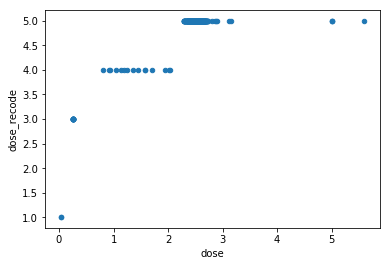

In [7]:
depmap_df.plot(x="dose", y="dose_recode", kind="scatter")

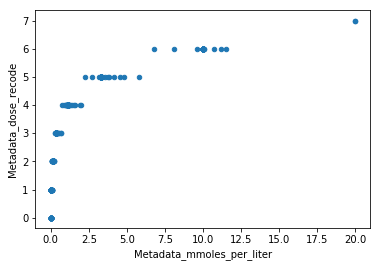

In [8]:
cell_health_df.plot(x="Metadata_mmoles_per_liter", y="Metadata_dose_recode", kind="scatter")

## Merge Together

In [9]:
full_df = (
    cell_health_df
    .merge(
        depmap_df,
        left_on=["Metadata_broad_sample", "Metadata_dose_recode"],
        right_on=["broad_id", "dose_recode"],
        how="inner"
    )
)

print(full_df.shape)
full_df.head(3)

(1436, 19)


,Metadata_broad_sample,Metadata_dose_recode,Metadata_mmoles_per_liter,Image_Metadata_Well,cell_health_viability,treatment_id,depmap_viability,column_name,broad_id,name,dose,screen_id,moa,target,disease.area,indication,smiles,phase,dose_recode
0,BRD-A00147595-001-01-5,5,3.333333,collapsed,-1.227843,BRD-A00147595-001-01-5::2.5::HTS,-0.477851,BRD-A00147595-001-01-5::2.5::HTS,BRD-A00147595-001-01-5,balaglitazone,2.5,HTS,"insulin sensitizer, PPAR receptor partial agonist",PPARG,NaN,NaN,Cn1c(COc2ccc(CC3SC(=O)NC3=O)cc2)nc2ccccc2c1=O,Phase 3,5
1,BRD-A00218260-001-03-4,5,3.333333,collapsed,-0.130889,BRD-A00218260-001-03-4::2.5::HTS,0.309237,BRD-A00218260-001-03-4::2.5::HTS,BRD-A00218260-001-03-4,flutrimazole,2.5,HTS,sterol demethylase inhibitor,NaN,infectious disease,mycosis,Fc1ccc(cc1)C(c1ccccc1)(c1ccccc1F)n1ccnc1,Launched,5
2,BRD-A00376169-001-01-6,5,3.333333,collapsed,0.194906,BRD-A00376169-001-01-6::2.5::HTS,-0.504880,BRD-A00376169-001-01-6::2.5::HTS,BRD-A00376169-001-01-6,KBG,2.5,HTS,neprilysin inhibitor,MME,NaN,NaN,OC1O[C@@H]2COC(O[C@H]2[C@H](O)[C@H]1O)c1ccccc1,Phase 2,5


## Obtain Results

In [10]:
spearman_cor = stats.spearmanr(full_df.cell_health_viability, full_df.depmap_viability)
spearman_cor = pd.DataFrame(spearman_cor, index=["stat", "p"]).transpose()
spearman_cor

,stat,p
0,0.257389,3.669143e-23


In [11]:
result_text = "Spearman = {0:.2f}\np = {1:.2E}".format(
    spearman_cor.stat[0],
    spearman_cor.p[0]
)

result_text

'Spearman = 0.26\np = 3.67E-23'

/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 5 x 3 in image.
  from_inches(height, units), units))
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/viability_results.png
  warn('Filename: {}'.format(filename))
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


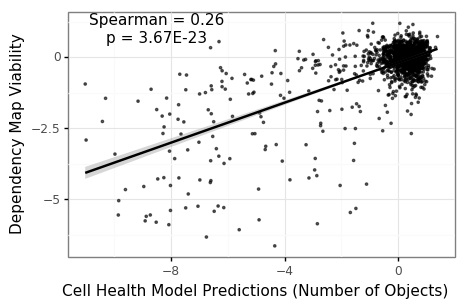

<ggplot: (303024704)>

In [12]:
viability_gg = (
    gg.ggplot(full_df, gg.aes(x="cell_health_viability", y="depmap_viability")) +
    gg.geom_point(size = 0.5, alpha = 0.6) +
    gg.theme_bw() +
    gg.geom_smooth() +
    gg.annotate("text", label = result_text, x = -8.5, y = 1) +
    gg.xlab("Cell Health Model Predictions (Number of Objects)") +
    gg.ylab("Dependency Map Viability") +
    gg.coord_fixed()
)

output_file = os.path.join("figures", "viability_results.png")
viability_gg.save(output_file, dpi = 400, height = 3, width = 5)

viability_gg